# Getting Started

## Printing the best bid and the best ask

In [1]:
from numba import njit

# numba.njit is strongly recommended for fast backtesting.
@njit
def print_bbo(hbt):
    # Iterating until hftbacktest reaches the end of data.
    while hbt.run:
        # Elapse 60-sec every iteration.
        # Time unit is the same as data's timestamp's unit.
        # timestamp of the sample data is in microseconds.
        if not hbt.elapse(60 * 1e6):
            # hftbacktest encounters the end of data while elapsing.
            return False
        
        # Print the best bid and the best offer.
        print(
            'current_timestamp:', hbt.current_timestamp,
            ', best_bid:', round(hbt.best_bid, 3),
            ', best_ask:', round(hbt.best_ask, 3)
        )
    return True

In [2]:
from hftbacktest import HftBacktest, FeedLatency, Linear

hbt = HftBacktest(
    'btcusdt_20230405.npz',
    tick_size=0.1,   # Tick size of a target trading asset
    lot_size=0.001,    # Lot size of a target trading asset, minimum trading unit.
    maker_fee=0.0002, # 0.02%, Maker fee, rebates if it is negative.
    taker_fee=0.0007, # 0.07%, Taker fee. 
    order_latency=FeedLatency(), # Latency model: ConstantLatency, FeedLatency.
    asset_type=Linear, # Asset type: Linear, Inverse.
    snapshot='btcusdt_20230404_eod.npz'
)

Load btcusdt_20230405.npz


You can see the best bid and the best ask every 60-sec.

In [3]:
print_bbo(hbt)

current_timestamp: 1680652860032116 , best_bid: 28150.7 , best_ask: 28150.8
current_timestamp: 1680652920032116 , best_bid: 28144.1 , best_ask: 28144.2
current_timestamp: 1680652980032116 , best_bid: 28149.9 , best_ask: 28150.0
current_timestamp: 1680653040032116 , best_bid: 28145.7 , best_ask: 28145.8
current_timestamp: 1680653100032116 , best_bid: 28140.5 , best_ask: 28140.6
current_timestamp: 1680653160032116 , best_bid: 28143.8 , best_ask: 28143.9


False

## Getting the market depth

In [4]:
@njit
def print_3depth(hbt):
    while hbt.run:
        if not hbt.elapse(60 * 1e6):
            return False
        
        # a key of bid_depth or ask_depth is price in tick format.
        # (integer) price_tick = price / tick_size
        print('current_timestamp:', hbt.current_timestamp)
        i = 0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                print(
                    'ask: ',
                    hbt.ask_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
        i = 0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                print(
                    'bid: ',
                    hbt.bid_depth[tick_price],
                    '@',
                    round(tick_price * hbt.tick_size, 3)
                )
                i += 1
                if i == 3:
                    break
    return True

In [5]:
import numpy as np

btcusdt_20230405 = np.load('btcusdt_20230405.npz')['data']
btcusdt_20230404_eod = np.load('btcusdt_20230404_eod.npz')['data']

In [6]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

print_3depth(hbt)

current_timestamp: 1680652860032116
ask:  9.228 @ 28150.8
ask:  0.387 @ 28150.9
ask:  3.996 @ 28151.0
bid:  3.135 @ 28150.7
bid:  0.002 @ 28150.6
bid:  0.813 @ 28150.5
current_timestamp: 1680652920032116
ask:  1.224 @ 28144.2
ask:  0.223 @ 28144.3
ask:  0.001 @ 28144.5
bid:  10.529 @ 28144.1
bid:  0.168 @ 28144.0
bid:  0.29 @ 28143.9
current_timestamp: 1680652980032116
ask:  3.397 @ 28150.0
ask:  1.282 @ 28150.1
ask:  0.003 @ 28150.4
bid:  7.951 @ 28149.9
bid:  0.02 @ 28149.8
bid:  0.02 @ 28149.7
current_timestamp: 1680653040032116
ask:  3.905 @ 28145.8
ask:  1.695 @ 28145.9
ask:  0.003 @ 28146.0
bid:  5.793 @ 28145.7
bid:  0.059 @ 28145.6
bid:  0.044 @ 28145.5
current_timestamp: 1680653100032116
ask:  6.8 @ 28140.6
ask:  0.001 @ 28140.7
ask:  0.004 @ 28141.1
bid:  2.416 @ 28140.5
bid:  0.004 @ 28140.4
bid:  0.012 @ 28140.3
current_timestamp: 1680653160032116
ask:  3.666 @ 28143.9
ask:  1.422 @ 28144.0
ask:  1.455 @ 28144.1
bid:  3.189 @ 28143.8
bid:  5.136 @ 28143.7
bid:  0.012 @ 2814

False

## Submitting an order

In [7]:
from hftbacktest import GTC, NONE, NEW, FILLED, CANCELED, EXPIRED

@njit
def print_orders(hbt):
    # You can access open orders and also closed orders via hbt.orders.
    # hbt.orders is a Numba dictionary and its key is order_id(int).
    for order_id, order in hbt.orders.items():
        order_status = ''
        if order.status == NONE:
            order_status = 'NONE' # Exchange hasn't received an order yet.
        elif order.status == NEW:
            order_status = 'NEW'
        elif order.status == FILLED:
            order_status = 'FILLED'
        elif order.status == CANCELED:
            order_status = 'CANCELED'
        elif order.status == EXPIRED:
            order_status = 'EXPIRED' 
            
        order_req = ''
        if order.req == NONE:
            order_req = 'NONE'
        elif order.req == NEW:
            order_req = 'NEW'
        elif order.req == CANCELED:
            order_req = 'CANCEL'
            
        print(
            'current_timestamp:', hbt.current_timestamp, 
             ', order_id:', order_id,
             ', order_price:', order.price,
             ', order_qty:', order.qty,
             ', order_status:', order_status,
             ', order_req:', order_req
        )

@njit
def submit_order(hbt):
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(30 * 1e6):
            return False
        
        # Print open orders.
        print_orders(hbt)
        
        if not is_order_submitted:
            # Submit a buy order at 100 tick below the best bid.
            order_id = 1
            order_price = hbt.best_bid - 100 * hbt.tick_size
            order_qty = 1
            time_in_force = GTC # Good 'till cancel
            hbt.submit_buy_order(order_id, order_price, order_qty, time_in_force)
            is_order_submitted = True
    return True

In [8]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

submit_order(hbt)

current_timestamp: 1680652860032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1680652890032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680652920032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680652950032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680652980032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680653010032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680653040032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_t

False

## Clearing inactive orders (FILLED, CANCELED, EXPIRED)

In [9]:
from hftbacktest import GTC

@njit
def clear_inactive_orders(hbt):
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(30 * 1e6):
            return False
        
        print_orders(hbt)
        
        # Remove inactive(FILLED, CANCELED, EXPIRED) orders from hbt.orders.
        hbt.clear_inactive_orders()
        
        if not is_order_submitted:
            order_id = 1
            order_price = hbt.best_bid - 100 * hbt.tick_size
            order_qty = 1
            time_in_force = GTC
            hbt.submit_buy_order(order_id, order_price, order_qty, time_in_force)
            is_order_submitted = True
    return True

In [10]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

clear_inactive_orders(hbt)

current_timestamp: 1680652860032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1680652890032116 , order_id: 1 , order_price: 28146.300000000003 , order_qty: 1.0 , order_status: FILLED , order_req: NONE


False

## Watching a order status - pending due to order latency

In [11]:
from hftbacktest import GTC

@njit
def watch_pending(hbt):
    is_order_submitted = False
    while hbt.run:
        # Elapse 0.01-sec every iteration.
        if not hbt.elapse(0.01 * 1e6):
            return False
        
        print_orders(hbt)
        
        hbt.clear_inactive_orders()
        
        if not is_order_submitted:
            order_id = 1
            order_price = hbt.best_bid - 100 * hbt.tick_size
            order_qty = 1
            time_in_force = GTC
            hbt.submit_buy_order(order_id, order_price, order_qty, time_in_force)
            is_order_submitted = True
            
        # Prevent too many prints
        if hbt.orders[order_id].status == NEW:
            return False
    return True

In [12]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

watch_pending(hbt)

current_timestamp: 1680652800052116 , order_id: 1 , order_price: 28145.100000000002 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1680652800062116 , order_id: 1 , order_price: 28145.100000000002 , order_qty: 1.0 , order_status: NONE , order_req: NEW
current_timestamp: 1680652800072116 , order_id: 1 , order_price: 28145.100000000002 , order_qty: 1.0 , order_status: NEW , order_req: NONE


False

## Waiting for an order response

In [13]:
from hftbacktest import GTC

@njit
def wait_for_order_response(hbt):
    order_id = 0
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(0.01 * 1e6):
            return False
        
        print_orders(hbt)
        
        hbt.clear_inactive_orders()
        
        # Prevent too many prints
        if order_id in hbt.orders:
            if hbt.orders[order_id].status == NEW:
                return False
        
        if not is_order_submitted:
            order_id = 1
            order_price = hbt.best_bid
            order_qty = 1
            time_in_force = GTC
            hbt.submit_buy_order(order_id, order_price, order_qty, time_in_force)
            # Wait for the order response for a given order id.
            print('an order is submitted at', hbt.current_timestamp)
            hbt.wait_order_response(order_id)
            print('an order response is received at', hbt.current_timestamp)
            is_order_submitted = True
    return True

In [14]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

wait_for_order_response(hbt)

an order is submitted at 1680652800042116
an order response is received at 1680652800070493
current_timestamp: 1680652800080493 , order_id: 1 , order_price: 28155.100000000002 , order_qty: 1.0 , order_status: NEW , order_req: NONE


False

## Printing position, balance, fee, and equity

In [15]:
@njit
def position(hbt):
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(60 * 1e6):
            return False
        
        print_orders(hbt)
        
        hbt.clear_inactive_orders()
        
        # Print position, balance, fee, and equity
        print(
            'current_timestamp:', hbt.current_timestamp,
            ', position:', hbt.position,
            ', balance:', hbt.balance,
            ', fee:', hbt.fee,
            ', equity:', hbt.equity
        )
        
        if not is_order_submitted:
            order_id = 1
            order_price = hbt.best_bid
            order_qty = 1
            time_in_force = GTC
            hbt.submit_buy_order(order_id, order_price, order_qty, time_in_force)
            hbt.wait_order_response(order_id)
            is_order_submitted = True
    return True

In [16]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

position(hbt)

current_timestamp: 1680652860032116 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
current_timestamp: 1680652920095398 , order_id: 1 , order_price: 28150.7 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680652920095398 , position: 1.0 , balance: -28150.7 , fee: 5.630140000000001 , equity: -12.180139999999273
current_timestamp: 1680652980095398 , position: 1.0 , balance: -28150.7 , fee: 5.630140000000001 , equity: -6.380140000000001
current_timestamp: 1680653040095398 , position: 1.0 , balance: -28150.7 , fee: 5.630140000000001 , equity: -10.580140000000728
current_timestamp: 1680653100095398 , position: 1.0 , balance: -28150.7 , fee: 5.630140000000001 , equity: -15.780139999997818
current_timestamp: 1680653160095398 , position: 1.0 , balance: -28150.7 , fee: 5.630140000000001 , equity: -12.480139999998546


False

## Canceling an open order

In [17]:
@njit
def submit_and_cancel_order(hbt):
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(0.1 * 1e6):
            return False
        
        print_orders(hbt)
        
        hbt.clear_inactive_orders()
        
        # Cancel if there is an open order
        for order_id, order in hbt.orders.items():
            # an order is only cancellable if order status is NEW.
            # cancel request is negated if the order is already filled or filled before cancel request is processed.
            if order.cancellable:
                hbt.cancel(order_id)
                # You can see status still NEW and see req CANCEL.
                print_orders(hbt)
                # cancel request also has order entry/response latencies the same as submitting.
                hbt.wait_order_response(order_id)
       
        if not is_order_submitted:
            order_id = 1
            order_price = hbt.best_bid - 100 * hbt.tick_size
            order_qty = 1
            time_in_force = GTC
            hbt.submit_buy_order(order_id, order_price, order_qty, time_in_force)
            hbt.wait_order_response(order_id)
            is_order_submitted = True
        else:
            if len(hbt.orders) == 0:
                return False
    return True

In [18]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

submit_and_cancel_order(hbt)

current_timestamp: 1680652800254816 , order_id: 1 , order_price: 28145.100000000002 , order_qty: 1.0 , order_status: NEW , order_req: NONE
current_timestamp: 1680652800254816 , order_id: 1 , order_price: 28145.100000000002 , order_qty: 1.0 , order_status: NEW , order_req: CANCEL
current_timestamp: 1680652800973764 , order_id: 1 , order_price: 28145.100000000002 , order_qty: 1.0 , order_status: CANCELED , order_req: NONE


False

## Market order

In [19]:
@njit
def print_orders_exec_price(hbt):
    for order_id, order in hbt.orders.items():
        order_status = ''
        if order.status == NONE:
            order_status = 'NONE'
        elif order.status == NEW:
            order_status = 'NEW'
        elif order.status == FILLED:
            order_status = 'FILLED'
        elif order.status == CANCELED:
            order_status = 'CANCELED'
        elif order.status == EXPIRED:
            order_status = 'EXPIRED' 
            
        order_req = ''
        if order.req == NONE:
            order_req = 'NONE'
        elif order.req == NEW:
            order_req = 'NEW'
        elif order.req == CANCELED:
            order_req = 'CANCEL'
            
        print(
            'current_timestamp:', hbt.current_timestamp, 
             ', order_id:', order_id,
             ', order_price:', order.price,
             ', order_qty:', order.qty,
             ', order_status:', order_status,
             ', exec_price:', order.exec_price
        )
        
@njit
def market_order(hbt):
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(60 * 1e6):
            return False
        
        print_orders(hbt)
        
        hbt.clear_inactive_orders()
        
        print(
            'current_timestamp:', hbt.current_timestamp,
             ', position:', hbt.position,
             ', balance:', hbt.balance,
             ', fee:', hbt.fee,
             ', equity:', hbt.equity
        )
        
        if not is_order_submitted:
            order_id = 1
            # Set a deep price in the opposite side to take liquidity.
            order_price = hbt.best_bid - 50 * hbt.tick_size
            order_qty = 1
            time_in_force = GTC
            hbt.submit_sell_order(order_id, order_price, order_qty, time_in_force)
            hbt.wait_order_response(order_id)
            # You can see the order immediately filled.
            # Also you can see the order executed at the best bid which is different from what it was submitted at.
            print('best_bid:', hbt.best_bid)
            print_orders_exec_price(hbt)            
            is_order_submitted = True
    return True

In [20]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

market_order(hbt)

current_timestamp: 1680652860032116 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
best_bid: 28150.7
current_timestamp: 1680652860095398 , order_id: 1 , order_price: 28145.7 , order_qty: 1.0 , order_status: FILLED , exec_price: 28150.7
current_timestamp: 1680652920095398 , order_id: 1 , order_price: 28145.7 , order_qty: 1.0 , order_status: FILLED , order_req: NONE
current_timestamp: 1680652920095398 , position: -1.0 , balance: 28150.7 , fee: 19.70549 , equity: -13.155490000000729
current_timestamp: 1680652980095398 , position: -1.0 , balance: 28150.7 , fee: 19.70549 , equity: -18.95549
current_timestamp: 1680653040095398 , position: -1.0 , balance: 28150.7 , fee: 19.70549 , equity: -14.755489999999273
current_timestamp: 1680653100095398 , position: -1.0 , balance: 28150.7 , fee: 19.70549 , equity: -9.555490000002184
current_timestamp: 1680653160095398 , position: -1.0 , balance: 28150.7 , fee: 19.70549 , equity: -12.855490000001456


False

## GTX, Post-Only order

In [21]:
from hftbacktest import GTX

@njit
def submit_gtx(hbt):
    is_order_submitted = False
    while hbt.run:
        if not hbt.elapse(60 * 1e6):
            return False
        
        print_orders(hbt)
        
        hbt.clear_inactive_orders()
        
        print(
            'current_timestamp:', hbt.current_timestamp,
             ', position:', hbt.position,
             ', balance:', hbt.balance,
             ', fee:', hbt.fee,
             ', equity:', hbt.equity
        )
        
        if not is_order_submitted:
            order_id = 1
            # Set a deep price in the opposite side and it will be rejected by GTX.
            order_price = hbt.best_bid - 100 * hbt.tick_size
            order_qty = 1
            time_in_force = GTX
            hbt.submit_sell_order(order_id, order_price, order_qty, time_in_force)
            hbt.wait_order_response(order_id)
            is_order_submitted = True
    return True

In [22]:
hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

submit_gtx(hbt)

current_timestamp: 1680652860032116 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
current_timestamp: 1680652920095398 , order_id: 1 , order_price: 28140.7 , order_qty: 1.0 , order_status: EXPIRED , order_req: NONE
current_timestamp: 1680652920095398 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
current_timestamp: 1680652980095398 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
current_timestamp: 1680653040095398 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
current_timestamp: 1680653100095398 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0
current_timestamp: 1680653160095398 , position: 0.0 , balance: 0.0 , fee: 0.0 , equity: 0.0


False

## Plotting BBO

In [23]:
@njit
def plot_bbo(hbt, local_timestamp, best_bid, best_ask):
    while hbt.run:
        if not hbt.elapse(1 * 1e6):
            return False

        # Record data points
        local_timestamp.append(hbt.current_timestamp)
        best_bid.append(hbt.best_bid)
        best_ask.append(hbt.best_ask)
    return True

<AxesSubplot:>

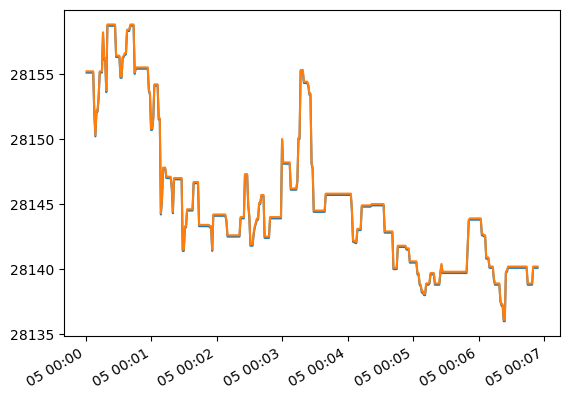

In [24]:
# Use Numba list for njit.
from numba.typed import List
from numba import float64

import pandas as pd

hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

local_timestamp = List.empty_list(float64, allocated=10000)
best_bid = List.empty_list(float64, allocated=10000)
best_ask = List.empty_list(float64, allocated=10000)

plot_bbo(hbt, local_timestamp, best_bid, best_ask)

local_timestamp = pd.to_datetime(local_timestamp, unit='us', utc=True)
best_bid = pd.Series(best_bid, index=local_timestamp)
best_ask = pd.Series(best_ask, index=local_timestamp)

best_bid.plot()
best_ask.plot()

## Printing stats

In [25]:
@njit
def submit_order_stats(hbt, recorder):
    buy_order_id = 1
    sell_order_id = 2
    half_spread = 1 * hbt.tick_size
    
    while hbt.run:
        if not hbt.elapse(1 * 1e6):
            return False
        
        hbt.clear_inactive_orders()
        
        mid = (hbt.best_bid + hbt.best_ask) / 2.0
        
        if buy_order_id not in hbt.orders:
            order_price = round((mid - half_spread) / hbt.tick_size) * hbt.tick_size
            order_qty = 1
            time_in_force = GTC
            hbt.submit_buy_order(buy_order_id, order_price, order_qty, time_in_force)
            
        if sell_order_id not in hbt.orders:
            order_price = round((mid + half_spread) / hbt.tick_size) * hbt.tick_size
            order_qty = 1
            time_in_force = GTC
            hbt.submit_sell_order(sell_order_id, order_price, order_qty, time_in_force)
            
        recorder.record(hbt)
    return True

=========== Summary ===========
Sharpe ratio: -355.7
Sortino ratio: -210.0
Risk return ratio: -52717.6
Annualised return: -31415.72 %
Max. draw down: 0.60 %
The number of trades per day: 9
Avg. daily trading volume: 9
Avg. daily trading amount: 255269
Max leverage: 12.66
Median leverage: 1.41


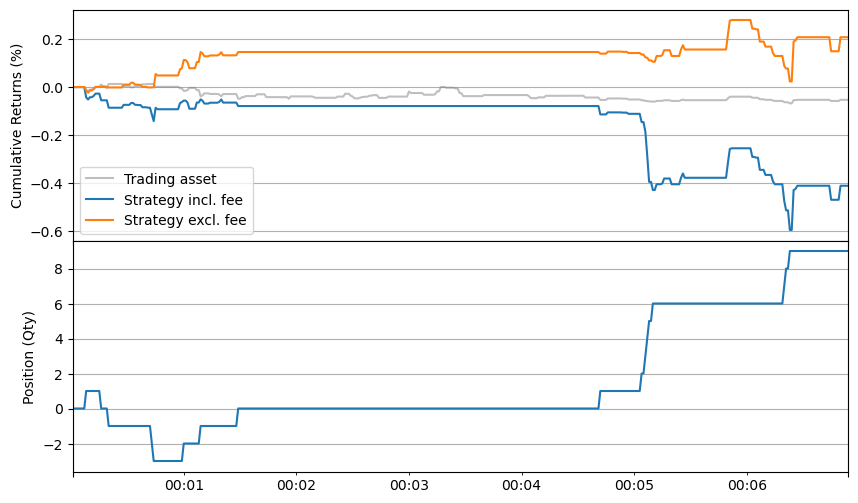

In [26]:
from hftbacktest import Stat

hbt = HftBacktest(
    btcusdt_20230405,
    tick_size=0.1,
    lot_size=0.001,
    maker_fee=0.0002,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    asset_type=Linear,
    snapshot=btcusdt_20230404_eod
)

stat = Stat(hbt)
submit_order_stats(hbt, stat.recorder)

# Default resample is 5min.
stat.summary(capital=20000, resample='1s')